## Import Dog Dataset 
In the code cell below, we import a dataset of dog images. We populate a few variables through the use of the load_files function from the scikit-learn library:

train_files, valid_files, test_files - numpy arrays containing file paths to images. <br>
train_targets, valid_targets, test_targets - numpy arrays containing onehot-encoded classification labels <br>
dog_names - list of string-valued dog breed names for translating labels

In [1]:
from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob

# define function to load train, test, and validation datasets
def load_dataset(path):
    data = load_files(path)
    dog_files = np.array(data['filenames'])
    dog_targets = np_utils.to_categorical(np.array(data['target']), 133)
    return dog_files, dog_targets

# load train, test, and validation datasets
train_files, train_targets = load_dataset('C:\\Users\\medipalle.tendulkar\\Desktop\\Kaggle DataSets\\Dog Breed Classifiers\\dogImages\\train')
valid_files, valid_targets = load_dataset('C:\\Users\\medipalle.tendulkar\\Desktop\\Kaggle DataSets\\Dog Breed Classifiers\\dogImages\\valid')
test_files, test_targets = load_dataset('C:\\Users\\medipalle.tendulkar\\Desktop\\Kaggle DataSets\\Dog Breed Classifiers\\dogImages\\test')

# load list of dog names
dog_names = [item[95:-1] for item in sorted(glob("C:\\Users\\medipalle.tendulkar\\Desktop\\Kaggle DataSets\\Dog Breed Classifiers\\dogImages\\train/*/"))]

# print statistics about the dataset
print('There are %d total dog categories.' % len(dog_names))
print('There are %s total dog images.\n' % len(np.hstack([train_files, valid_files, test_files])))
print('There are %d training dog images.' % len(train_files))
print('There are %d validation dog images.' % len(valid_files))
print('There are %d test dog images.'% len(test_files))

Using TensorFlow backend.


There are 133 total dog categories.
There are 8351 total dog images.

There are 6680 training dog images.
There are 835 validation dog images.
There are 836 test dog images.


## Import Human Dataset <br>
In the code cell below, we import a dataset of human images, where the file paths are stored in the numpy array human_files.

In [2]:
import random
random.seed(8675309)

# load filenames in shuffled human dataset
human_files = np.array(glob("C:\\Users\\medipalle.tendulkar\\Desktop\\Kaggle DataSets\\Dog Breed Classifiers\\lfw\\*\\*"))
random.shuffle(human_files)

# print statistics about the dataset
print('There are %d total human images.' % len(human_files))

There are 13233 total human images.


####  Detect Humans<br>
We use OpenCV's implementation of Haar feature-based cascade classifiers to detect human faces in images. OpenCV provides many pre-trained face detectors, stored as XML files. <br>

In the next code cell, we demonstrate how to use this detector to find human faces in a sample image.

Number of faces detected: 2


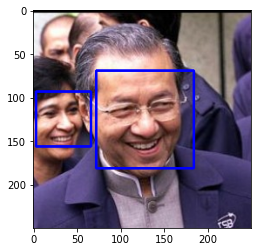

In [3]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('C:\\Users\\medipalle.tendulkar\\Desktop\\Kaggle DataSets\\Dog Breed Classifiers\\haarcascades\\haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[14])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

In [4]:
# Function to detect Human Faces
#  The face_detector function takes a string-valued file path to an image as input and returns True if a human face is detected in an image and False otherwise
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

####  Detect Dogs
In this section, we use a pre-trained ResNet-50 model to detect dogs in images. Our first line of code downloads the ResNet-50 model, along with weights that have been trained on ImageNet, a very large, very popular dataset used for image classification and other vision tasks

In [5]:
from keras.applications.resnet50 import ResNet50

# define ResNet50 model
ResNet50_model = ResNet50(weights='imagenet')

When using TensorFlow as backend, Keras CNNs require a 4D array (which we’ll also refer to as a 4D tensor) as input, with shape<br>
$$
(\text{nb_samples}, \text{rows}, \text{columns}, \text{channels}),
$$
where nb_samples corresponds to the total number of images (or samples), and rows, columns, and channels correspond to the number of rows, columns, and channels for each image, respectively.<br>
The path_to_tensor function below takes a string-valued file path to a color image as input and returns a 4D tensor suitable for supplying to a Keras CNN. The function first loads the image and resizes it to a square image that is $224 \times 224$ pixels. Next, the image is converted to an array, which is then resized to a 4D tensor. In this case, since we are working with color images, each image has three channels. Likewise, since we are processing a single image (or sample), the returned tensor will always have shape

$$
(1, 224, 224, 3).
$$
The paths_to_tensor function takes a numpy array of string-valued image paths as input and returns a 4D tensor with shape

$$
(\text{nb_samples}, 224, 224, 3).
$$
Here, nb_samples is the number of samples, or number of images, in the supplied array of image paths. It is best to think of nb_samples as the number of 3D tensors (where each 3D tensor corresponds to a different image) in your dataset!

In [6]:
from keras.preprocessing import image                  
from tqdm import tqdm

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

In addition, ResNet-50 requires additional processing such as reordering of channels from RGB to BGR and normalization of pixels which is done using preprocess_input.<br>
The model is then used to extract the predictions. The predict method, returns an array whose 𝑖-th entry is the model's predicted probability that the image belongs to the 𝑖-th ImageNet category. This is implemented in the ResNet50_predict_labels function below.

In [7]:
from keras.applications.resnet50 import preprocess_input, decode_predictions

def ResNet50_predict_labels(img_path):
    # returns prediction vector for image located at img_path
    img = preprocess_input(path_to_tensor(img_path))
    return np.argmax(ResNet50_model.predict(img))

While looking at the dictionary, you will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from 'Chihuahua' to 'Mexican hairless'.<br> Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained ResNet-50 model, we need only check if the ResNet50_predict_labels function above returns a value between 151 and 268 (inclusive)

In [8]:
## Function to detect DOG Images
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    prediction = ResNet50_predict_labels(img_path)
    return ((prediction <= 268) & (prediction >= 151))

## Create a CNN to Classify Dog Breeds (from Scratch)

### Pre-process the Data
We rescale the images by dividing every pixel in every image by 255.

In [9]:
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# pre-process the data for Keras
train_tensors = paths_to_tensor(train_files).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255

100%|██████████| 836/836 [00:06<00:00, 139.17it/s]


In [10]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential

model = Sequential()

### TODO: Define your architecture.

model.add(Conv2D(filters=16, kernel_size=2, padding='same', activation='relu',input_shape=(train_tensors.shape[1:]) ))
# Shape (223, 223, 16)
model.add(MaxPooling2D(pool_size=2)) 
# Reduces size of the first two parameters, 223/2 = 111; Shape (111, 111, 16)
model.add(Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
# Increases filters to 32; Shape (110, 110, 32)
model.add(MaxPooling2D(pool_size=2))
# Pools the first two parameters by 2, 110/2 = 55; Shape (55, 55, 32)
model.add(Conv2D(filters=64, kernel_size=2, padding='same', activation='relu'))
# Increases filters to 64, Shape (54, 54, 64)
model.add(MaxPooling2D(pool_size=2))
# Pools the first two parameters by 2, 54/2 = 27; Shape (27, 27, 64)
model.add(GlobalAveragePooling2D(data_format=None))
# By using global average pooling you make the data one dimensional; Shape (None, 64)
model.add(Dense(133, activation='softmax'))
# We are classifying the dogs into 133 different dog breeds, so the end result should be an object with a shape of 133
# Shape (None, 133)
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 224, 224, 16)      208       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 32)      2080      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 56, 56, 64)        8256      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 28, 28, 64)        0         
_________________________________________________________________
global_average_pooling2d_1 ( (None, 64)               

### Compile the Model

In [11]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [12]:
# Train the model
## Train your model in the code cell below. Use model checkpointing to save the model that attains the best validation loss.
from keras.callbacks import ModelCheckpoint  

checkpointer = ModelCheckpoint(filepath='C:\\Users\\medipalle.tendulkar\\Desktop\Kaggle DataSets\\Dog Breed Classifiers\\saved_models\\weights.best.from_scratch.hdf5', 
                               verbose=1, save_best_only=True)

model.fit(train_tensors, train_targets, 
         validation_data=(valid_tensors, valid_targets),
          epochs=10, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/10


3680/6680 [===============>..............] - ETA: 3:08 - loss: 4.8978 - accuracy: 0.0000e+ - ETA: 2:18 - loss: 4.8935 - accuracy: 0.0000e+ - ETA: 2:01 - loss: 4.8948 - accuracy: 0.0167   - ETA: 1:54 - loss: 4.8943 - accuracy: 0.01 - ETA: 1:48 - loss: 4.8924 - accuracy: 0.01 - ETA: 1:46 - loss: 4.8919 - accuracy: 0.00 - ETA: 1:43 - loss: 4.8928 - accuracy: 0.00 - ETA: 1:40 - loss: 4.8929 - accuracy: 0.00 - ETA: 1:39 - loss: 4.8913 - accuracy: 0.01 - ETA: 1:37 - loss: 4.8920 - accuracy: 0.01 - ETA: 1:36 - loss: 4.8925 - accuracy: 0.00 - ETA: 1:35 - loss: 4.8920 - accuracy: 0.00 - ETA: 1:34 - loss: 4.8916 - accuracy: 0.00 - ETA: 1:33 - loss: 4.8911 - accuracy: 0.00 - ETA: 1:32 - loss: 4.8919 - accuracy: 0.00 - ETA: 1:31 - loss: 4.8913 - accuracy: 0.00 - ETA: 1:31 - loss: 4.8912 - accuracy: 0.00 - ETA: 1:30 - loss: 4.8907 - accuracy: 0.00 - ETA: 1:30 - loss: 4.8910 - accuracy: 0.00 - ETA: 1:29 - loss: 4.8903 - accuracy: 0.00 - ETA: 1:28 - loss: 4.8899 - accuracy: 0.00 - ETA: 1:28 - loss: 4

3720/6680 [===============>..............] - ETA: 1:53 - loss: 4.8835 - accuracy: 0.0000e+ - ETA: 2:00 - loss: 4.8469 - accuracy: 0.0250   - ETA: 1:58 - loss: 4.8527 - accuracy: 0.03 - ETA: 1:54 - loss: 4.8466 - accuracy: 0.02 - ETA: 1:54 - loss: 4.8428 - accuracy: 0.02 - ETA: 1:52 - loss: 4.8544 - accuracy: 0.01 - ETA: 1:50 - loss: 4.8652 - accuracy: 0.01 - ETA: 1:49 - loss: 4.8654 - accuracy: 0.01 - ETA: 1:47 - loss: 4.8630 - accuracy: 0.01 - ETA: 1:46 - loss: 4.8581 - accuracy: 0.01 - ETA: 1:46 - loss: 4.8589 - accuracy: 0.01 - ETA: 1:45 - loss: 4.8550 - accuracy: 0.01 - ETA: 1:44 - loss: 4.8630 - accuracy: 0.01 - ETA: 1:44 - loss: 4.8595 - accuracy: 0.01 - ETA: 1:44 - loss: 4.8610 - accuracy: 0.01 - ETA: 1:44 - loss: 4.8602 - accuracy: 0.00 - ETA: 1:43 - loss: 4.8620 - accuracy: 0.00 - ETA: 1:44 - loss: 4.8632 - accuracy: 0.01 - ETA: 1:44 - loss: 4.8619 - accuracy: 0.01 - ETA: 1:43 - loss: 4.8610 - accuracy: 0.01 - ETA: 1:43 - loss: 4.8617 - accuracy: 0.01 - ETA: 1:43 - loss: 4.861

6680/6680 [==============================] - ETA: 47s - loss: 4.8617 - accuracy: 0.014 - ETA: 46s - loss: 4.8612 - accuracy: 0.014 - ETA: 46s - loss: 4.8618 - accuracy: 0.014 - ETA: 46s - loss: 4.8621 - accuracy: 0.014 - ETA: 45s - loss: 4.8623 - accuracy: 0.014 - ETA: 45s - loss: 4.8621 - accuracy: 0.014 - ETA: 45s - loss: 4.8622 - accuracy: 0.014 - ETA: 44s - loss: 4.8622 - accuracy: 0.014 - ETA: 44s - loss: 4.8625 - accuracy: 0.014 - ETA: 44s - loss: 4.8623 - accuracy: 0.014 - ETA: 43s - loss: 4.8621 - accuracy: 0.014 - ETA: 43s - loss: 4.8620 - accuracy: 0.013 - ETA: 43s - loss: 4.8625 - accuracy: 0.013 - ETA: 43s - loss: 4.8621 - accuracy: 0.013 - ETA: 42s - loss: 4.8621 - accuracy: 0.013 - ETA: 42s - loss: 4.8626 - accuracy: 0.013 - ETA: 42s - loss: 4.8629 - accuracy: 0.013 - ETA: 41s - loss: 4.8624 - accuracy: 0.013 - ETA: 41s - loss: 4.8624 - accuracy: 0.013 - ETA: 41s - loss: 4.8624 - accuracy: 0.013 - ETA: 40s - loss: 4.8619 - accuracy: 0.013 - ETA: 40s - loss: 4.8619 - accur

3720/6680 [===============>..............] - ETA: 1:39 - loss: 4.6912 - accuracy: 0.05 - ETA: 1:38 - loss: 4.7962 - accuracy: 0.02 - ETA: 1:40 - loss: 4.8029 - accuracy: 0.03 - ETA: 1:40 - loss: 4.8025 - accuracy: 0.02 - ETA: 1:40 - loss: 4.7939 - accuracy: 0.03 - ETA: 1:40 - loss: 4.7868 - accuracy: 0.02 - ETA: 1:40 - loss: 4.7687 - accuracy: 0.02 - ETA: 1:40 - loss: 4.7832 - accuracy: 0.01 - ETA: 1:40 - loss: 4.7782 - accuracy: 0.02 - ETA: 1:39 - loss: 4.7742 - accuracy: 0.03 - ETA: 1:38 - loss: 4.7807 - accuracy: 0.02 - ETA: 1:38 - loss: 4.7823 - accuracy: 0.02 - ETA: 1:38 - loss: 4.7860 - accuracy: 0.02 - ETA: 1:38 - loss: 4.7965 - accuracy: 0.02 - ETA: 1:37 - loss: 4.7945 - accuracy: 0.02 - ETA: 1:37 - loss: 4.7896 - accuracy: 0.02 - ETA: 1:37 - loss: 4.7883 - accuracy: 0.02 - ETA: 1:37 - loss: 4.7857 - accuracy: 0.03 - ETA: 1:36 - loss: 4.7841 - accuracy: 0.02 - ETA: 1:35 - loss: 4.7869 - accuracy: 0.02 - ETA: 1:35 - loss: 4.7870 - accuracy: 0.02 - ETA: 1:34 - loss: 4.7872 - accu

3720/6680 [===============>..............] - ETA: 1:39 - loss: 4.7368 - accuracy: 0.05 - ETA: 1:42 - loss: 4.7609 - accuracy: 0.02 - ETA: 1:40 - loss: 4.7536 - accuracy: 0.03 - ETA: 1:40 - loss: 4.7484 - accuracy: 0.03 - ETA: 1:41 - loss: 4.7709 - accuracy: 0.03 - ETA: 1:40 - loss: 4.7861 - accuracy: 0.03 - ETA: 1:40 - loss: 4.7872 - accuracy: 0.02 - ETA: 1:40 - loss: 4.7859 - accuracy: 0.02 - ETA: 1:40 - loss: 4.7852 - accuracy: 0.02 - ETA: 1:40 - loss: 4.7711 - accuracy: 0.02 - ETA: 1:39 - loss: 4.7774 - accuracy: 0.02 - ETA: 1:39 - loss: 4.7846 - accuracy: 0.02 - ETA: 1:38 - loss: 4.7782 - accuracy: 0.01 - ETA: 1:38 - loss: 4.7882 - accuracy: 0.02 - ETA: 1:37 - loss: 4.7936 - accuracy: 0.02 - ETA: 1:36 - loss: 4.7910 - accuracy: 0.01 - ETA: 1:36 - loss: 4.7905 - accuracy: 0.01 - ETA: 1:35 - loss: 4.7919 - accuracy: 0.01 - ETA: 1:35 - loss: 4.7964 - accuracy: 0.01 - ETA: 1:34 - loss: 4.7898 - accuracy: 0.01 - ETA: 1:34 - loss: 4.8002 - accuracy: 0.01 - ETA: 1:33 - loss: 4.7974 - accu

6680/6680 [==============================] - ETA: 44s - loss: 4.7938 - accuracy: 0.018 - ETA: 44s - loss: 4.7943 - accuracy: 0.018 - ETA: 44s - loss: 4.7944 - accuracy: 0.018 - ETA: 43s - loss: 4.7950 - accuracy: 0.018 - ETA: 43s - loss: 4.7946 - accuracy: 0.018 - ETA: 43s - loss: 4.7944 - accuracy: 0.018 - ETA: 43s - loss: 4.7942 - accuracy: 0.018 - ETA: 42s - loss: 4.7939 - accuracy: 0.018 - ETA: 42s - loss: 4.7934 - accuracy: 0.018 - ETA: 42s - loss: 4.7933 - accuracy: 0.018 - ETA: 41s - loss: 4.7937 - accuracy: 0.018 - ETA: 41s - loss: 4.7927 - accuracy: 0.018 - ETA: 41s - loss: 4.7928 - accuracy: 0.018 - ETA: 40s - loss: 4.7928 - accuracy: 0.018 - ETA: 40s - loss: 4.7940 - accuracy: 0.018 - ETA: 40s - loss: 4.7943 - accuracy: 0.018 - ETA: 40s - loss: 4.7937 - accuracy: 0.018 - ETA: 39s - loss: 4.7940 - accuracy: 0.018 - ETA: 39s - loss: 4.7933 - accuracy: 0.018 - ETA: 39s - loss: 4.7933 - accuracy: 0.018 - ETA: 39s - loss: 4.7925 - accuracy: 0.017 - ETA: 38s - loss: 4.7926 - accur

3700/6680 [===============>..............] - ETA: 1:38 - loss: 4.6734 - accuracy: 0.0000e+ - ETA: 1:41 - loss: 4.7877 - accuracy: 0.0000e+ - ETA: 1:41 - loss: 4.7788 - accuracy: 0.0167   - ETA: 1:41 - loss: 4.7964 - accuracy: 0.01 - ETA: 1:41 - loss: 4.7998 - accuracy: 0.01 - ETA: 1:42 - loss: 4.8135 - accuracy: 0.00 - ETA: 1:43 - loss: 4.8168 - accuracy: 0.00 - ETA: 1:43 - loss: 4.8144 - accuracy: 0.01 - ETA: 1:42 - loss: 4.8212 - accuracy: 0.01 - ETA: 1:42 - loss: 4.8089 - accuracy: 0.01 - ETA: 1:41 - loss: 4.8144 - accuracy: 0.00 - ETA: 1:41 - loss: 4.8156 - accuracy: 0.00 - ETA: 1:40 - loss: 4.7968 - accuracy: 0.01 - ETA: 1:39 - loss: 4.8067 - accuracy: 0.01 - ETA: 1:39 - loss: 4.8036 - accuracy: 0.01 - ETA: 1:38 - loss: 4.8075 - accuracy: 0.00 - ETA: 1:38 - loss: 4.8088 - accuracy: 0.00 - ETA: 1:37 - loss: 4.8053 - accuracy: 0.01 - ETA: 1:36 - loss: 4.8064 - accuracy: 0.01 - ETA: 1:36 - loss: 4.8073 - accuracy: 0.01 - ETA: 1:35 - loss: 4.8092 - accuracy: 0.00 - ETA: 1:35 - loss: 4

3720/6680 [===============>..............] - ETA: 1:34 - loss: 4.8457 - accuracy: 0.05 - ETA: 1:35 - loss: 4.7585 - accuracy: 0.05 - ETA: 1:35 - loss: 4.7176 - accuracy: 0.05 - ETA: 1:35 - loss: 4.6473 - accuracy: 0.06 - ETA: 1:36 - loss: 4.6258 - accuracy: 0.05 - ETA: 1:36 - loss: 4.6496 - accuracy: 0.04 - ETA: 1:36 - loss: 4.6923 - accuracy: 0.04 - ETA: 1:36 - loss: 4.6905 - accuracy: 0.03 - ETA: 1:35 - loss: 4.7115 - accuracy: 0.03 - ETA: 1:35 - loss: 4.7000 - accuracy: 0.03 - ETA: 1:35 - loss: 4.6988 - accuracy: 0.03 - ETA: 1:35 - loss: 4.7054 - accuracy: 0.02 - ETA: 1:35 - loss: 4.6783 - accuracy: 0.03 - ETA: 1:35 - loss: 4.6754 - accuracy: 0.03 - ETA: 1:34 - loss: 4.6952 - accuracy: 0.03 - ETA: 1:34 - loss: 4.6838 - accuracy: 0.03 - ETA: 1:34 - loss: 4.6914 - accuracy: 0.03 - ETA: 1:33 - loss: 4.6861 - accuracy: 0.03 - ETA: 1:33 - loss: 4.6880 - accuracy: 0.02 - ETA: 1:33 - loss: 4.6839 - accuracy: 0.03 - ETA: 1:32 - loss: 4.6738 - accuracy: 0.03 - ETA: 1:32 - loss: 4.6724 - accu

6680/6680 [==============================] - ETA: 43s - loss: 4.7389 - accuracy: 0.021 - ETA: 43s - loss: 4.7394 - accuracy: 0.021 - ETA: 43s - loss: 4.7398 - accuracy: 0.020 - ETA: 42s - loss: 4.7386 - accuracy: 0.021 - ETA: 42s - loss: 4.7391 - accuracy: 0.020 - ETA: 42s - loss: 4.7402 - accuracy: 0.020 - ETA: 42s - loss: 4.7411 - accuracy: 0.020 - ETA: 41s - loss: 4.7418 - accuracy: 0.020 - ETA: 41s - loss: 4.7416 - accuracy: 0.020 - ETA: 41s - loss: 4.7418 - accuracy: 0.020 - ETA: 40s - loss: 4.7416 - accuracy: 0.020 - ETA: 40s - loss: 4.7416 - accuracy: 0.020 - ETA: 40s - loss: 4.7410 - accuracy: 0.020 - ETA: 39s - loss: 4.7413 - accuracy: 0.020 - ETA: 39s - loss: 4.7404 - accuracy: 0.020 - ETA: 39s - loss: 4.7399 - accuracy: 0.020 - ETA: 39s - loss: 4.7396 - accuracy: 0.020 - ETA: 38s - loss: 4.7397 - accuracy: 0.020 - ETA: 38s - loss: 4.7395 - accuracy: 0.020 - ETA: 38s - loss: 4.7393 - accuracy: 0.020 - ETA: 37s - loss: 4.7383 - accuracy: 0.021 - ETA: 37s - loss: 4.7384 - accur

3700/6680 [===============>..............] - ETA: 1:34 - loss: 4.8587 - accuracy: 0.0000e+ - ETA: 1:35 - loss: 4.8021 - accuracy: 0.0000e+ - ETA: 1:35 - loss: 4.7300 - accuracy: 0.0000e+ - ETA: 1:36 - loss: 4.7219 - accuracy: 0.0125   - ETA: 1:37 - loss: 4.7301 - accuracy: 0.02 - ETA: 1:37 - loss: 4.7480 - accuracy: 0.01 - ETA: 1:37 - loss: 4.7447 - accuracy: 0.01 - ETA: 1:37 - loss: 4.7509 - accuracy: 0.01 - ETA: 1:38 - loss: 4.7364 - accuracy: 0.01 - ETA: 1:37 - loss: 4.7556 - accuracy: 0.01 - ETA: 1:37 - loss: 4.7538 - accuracy: 0.01 - ETA: 1:36 - loss: 4.7469 - accuracy: 0.01 - ETA: 1:36 - loss: 4.7304 - accuracy: 0.01 - ETA: 1:35 - loss: 4.7276 - accuracy: 0.01 - ETA: 1:35 - loss: 4.7273 - accuracy: 0.01 - ETA: 1:34 - loss: 4.7263 - accuracy: 0.01 - ETA: 1:34 - loss: 4.7303 - accuracy: 0.01 - ETA: 1:34 - loss: 4.7430 - accuracy: 0.01 - ETA: 1:34 - loss: 4.7337 - accuracy: 0.01 - ETA: 1:33 - loss: 4.7281 - accuracy: 0.01 - ETA: 1:33 - loss: 4.7185 - accuracy: 0.01 - ETA: 1:33 - los

3700/6680 [===============>..............] - ETA: 1:36 - loss: 4.9048 - accuracy: 0.0000e+ - ETA: 1:35 - loss: 4.7809 - accuracy: 0.0000e+ - ETA: 1:36 - loss: 4.7533 - accuracy: 0.0000e+ - ETA: 1:39 - loss: 4.7856 - accuracy: 0.0125   - ETA: 1:39 - loss: 4.7686 - accuracy: 0.01 - ETA: 1:38 - loss: 4.7861 - accuracy: 0.01 - ETA: 1:38 - loss: 4.7601 - accuracy: 0.01 - ETA: 1:37 - loss: 4.7485 - accuracy: 0.01 - ETA: 1:37 - loss: 4.7556 - accuracy: 0.02 - ETA: 1:37 - loss: 4.7373 - accuracy: 0.02 - ETA: 1:37 - loss: 4.7410 - accuracy: 0.01 - ETA: 1:37 - loss: 4.7558 - accuracy: 0.02 - ETA: 1:37 - loss: 4.7457 - accuracy: 0.02 - ETA: 1:38 - loss: 4.7245 - accuracy: 0.02 - ETA: 1:38 - loss: 4.7252 - accuracy: 0.02 - ETA: 1:38 - loss: 4.7113 - accuracy: 0.02 - ETA: 1:38 - loss: 4.7176 - accuracy: 0.02 - ETA: 1:38 - loss: 4.7043 - accuracy: 0.02 - ETA: 1:38 - loss: 4.6995 - accuracy: 0.02 - ETA: 1:38 - loss: 4.7113 - accuracy: 0.02 - ETA: 1:38 - loss: 4.7095 - accuracy: 0.02 - ETA: 1:38 - los

6680/6680 [==============================] - ETA: 44s - loss: 4.7015 - accuracy: 0.027 - ETA: 44s - loss: 4.7014 - accuracy: 0.027 - ETA: 43s - loss: 4.7017 - accuracy: 0.027 - ETA: 43s - loss: 4.7011 - accuracy: 0.027 - ETA: 43s - loss: 4.7011 - accuracy: 0.027 - ETA: 42s - loss: 4.7009 - accuracy: 0.027 - ETA: 42s - loss: 4.7018 - accuracy: 0.026 - ETA: 42s - loss: 4.7023 - accuracy: 0.026 - ETA: 41s - loss: 4.7029 - accuracy: 0.026 - ETA: 41s - loss: 4.7036 - accuracy: 0.026 - ETA: 41s - loss: 4.7033 - accuracy: 0.026 - ETA: 41s - loss: 4.7033 - accuracy: 0.026 - ETA: 40s - loss: 4.7020 - accuracy: 0.026 - ETA: 40s - loss: 4.7013 - accuracy: 0.026 - ETA: 40s - loss: 4.7018 - accuracy: 0.026 - ETA: 39s - loss: 4.7014 - accuracy: 0.026 - ETA: 39s - loss: 4.7017 - accuracy: 0.026 - ETA: 39s - loss: 4.7010 - accuracy: 0.026 - ETA: 38s - loss: 4.6999 - accuracy: 0.027 - ETA: 38s - loss: 4.7007 - accuracy: 0.027 - ETA: 38s - loss: 4.7016 - accuracy: 0.026 - ETA: 38s - loss: 4.7009 - accur

3720/6680 [===============>..............] - ETA: 1:33 - loss: 4.4733 - accuracy: 0.05 - ETA: 1:34 - loss: 4.6015 - accuracy: 0.02 - ETA: 1:35 - loss: 4.6653 - accuracy: 0.01 - ETA: 1:34 - loss: 4.6634 - accuracy: 0.02 - ETA: 1:34 - loss: 4.6754 - accuracy: 0.03 - ETA: 1:34 - loss: 4.6545 - accuracy: 0.03 - ETA: 1:35 - loss: 4.6543 - accuracy: 0.03 - ETA: 1:35 - loss: 4.6755 - accuracy: 0.03 - ETA: 1:36 - loss: 4.6796 - accuracy: 0.03 - ETA: 1:36 - loss: 4.6600 - accuracy: 0.04 - ETA: 1:36 - loss: 4.6673 - accuracy: 0.04 - ETA: 1:36 - loss: 4.6745 - accuracy: 0.03 - ETA: 1:36 - loss: 4.6638 - accuracy: 0.03 - ETA: 1:35 - loss: 4.6624 - accuracy: 0.03 - ETA: 1:35 - loss: 4.6640 - accuracy: 0.04 - ETA: 1:34 - loss: 4.6759 - accuracy: 0.03 - ETA: 1:34 - loss: 4.6817 - accuracy: 0.03 - ETA: 1:33 - loss: 4.6901 - accuracy: 0.03 - ETA: 1:33 - loss: 4.6905 - accuracy: 0.03 - ETA: 1:33 - loss: 4.6887 - accuracy: 0.03 - ETA: 1:32 - loss: 4.6875 - accuracy: 0.03 - ETA: 1:32 - loss: 4.6899 - accu

3700/6680 [===============>..............] - ETA: 1:43 - loss: 4.6139 - accuracy: 0.0000e+ - ETA: 1:46 - loss: 4.7915 - accuracy: 0.0000e+ - ETA: 1:45 - loss: 4.6695 - accuracy: 0.0333   - ETA: 1:43 - loss: 4.6388 - accuracy: 0.02 - ETA: 1:41 - loss: 4.6171 - accuracy: 0.02 - ETA: 1:40 - loss: 4.7099 - accuracy: 0.01 - ETA: 1:39 - loss: 4.7004 - accuracy: 0.02 - ETA: 1:39 - loss: 4.6920 - accuracy: 0.02 - ETA: 1:40 - loss: 4.6719 - accuracy: 0.02 - ETA: 1:40 - loss: 4.6874 - accuracy: 0.02 - ETA: 1:40 - loss: 4.6762 - accuracy: 0.03 - ETA: 1:39 - loss: 4.6738 - accuracy: 0.02 - ETA: 1:38 - loss: 4.6823 - accuracy: 0.02 - ETA: 1:38 - loss: 4.6682 - accuracy: 0.02 - ETA: 1:37 - loss: 4.6643 - accuracy: 0.03 - ETA: 1:36 - loss: 4.6622 - accuracy: 0.03 - ETA: 1:36 - loss: 4.6601 - accuracy: 0.03 - ETA: 1:36 - loss: 4.6676 - accuracy: 0.03 - ETA: 1:35 - loss: 4.6679 - accuracy: 0.03 - ETA: 1:35 - loss: 4.6735 - accuracy: 0.03 - ETA: 1:34 - loss: 4.6687 - accuracy: 0.03 - ETA: 1:34 - loss: 4

6680/6680 [==============================] - ETA: 46s - loss: 4.6674 - accuracy: 0.031 - ETA: 46s - loss: 4.6680 - accuracy: 0.031 - ETA: 45s - loss: 4.6681 - accuracy: 0.031 - ETA: 45s - loss: 4.6682 - accuracy: 0.032 - ETA: 45s - loss: 4.6681 - accuracy: 0.031 - ETA: 45s - loss: 4.6682 - accuracy: 0.031 - ETA: 44s - loss: 4.6688 - accuracy: 0.031 - ETA: 44s - loss: 4.6689 - accuracy: 0.031 - ETA: 44s - loss: 4.6690 - accuracy: 0.031 - ETA: 43s - loss: 4.6693 - accuracy: 0.031 - ETA: 43s - loss: 4.6695 - accuracy: 0.031 - ETA: 43s - loss: 4.6698 - accuracy: 0.031 - ETA: 43s - loss: 4.6698 - accuracy: 0.031 - ETA: 42s - loss: 4.6701 - accuracy: 0.031 - ETA: 42s - loss: 4.6699 - accuracy: 0.031 - ETA: 42s - loss: 4.6686 - accuracy: 0.031 - ETA: 41s - loss: 4.6678 - accuracy: 0.031 - ETA: 41s - loss: 4.6673 - accuracy: 0.031 - ETA: 41s - loss: 4.6670 - accuracy: 0.031 - ETA: 41s - loss: 4.6671 - accuracy: 0.031 - ETA: 40s - loss: 4.6667 - accuracy: 0.031 - ETA: 40s - loss: 4.6679 - accur

In [13]:
# Load the model with best Validation loss

model.load_weights('C:\\Users\\medipalle.tendulkar\\Desktop\Kaggle DataSets\\Dog Breed Classifiers\\saved_models\\weights.best.from_scratch.hdf5')

### Test the Model<br>
Try out your model on the test dataset of dog images. Ensure that your test accuracy is greater than 1%.

In [14]:
# get index of predicted dog breed for each image in test set
dog_breed_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

# report test accuracy
test_accuracy = 100*np.sum(np.array(dog_breed_predictions)==np.argmax(test_targets, axis=1))/len(dog_breed_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 3.7081%


## Use a CNN to Classify Dog Breeds
To reduce training time without sacrificing accuracy, we show you how to train a CNN using transfer learning. In the following step, you will get a chance to use transfer learning to train your own CNN.

In [15]:
# Obtain Bottleneck Features

bottleneck_features = np.load('C:\\Users\\medipalle.tendulkar\\Desktop\\Kaggle DataSets\\Dog Breed Classifiers\\bottleneck_features\\DogVGG16Data.npz')
train_VGG16 = bottleneck_features['train']
valid_VGG16 = bottleneck_features['valid']
test_VGG16 = bottleneck_features['test']

In [16]:
## Model vgg16

VGG16_model = Sequential()
VGG16_model.add(GlobalAveragePooling2D(input_shape=train_VGG16.shape[1:]))
VGG16_model.add(Dense(133, activation='softmax'))

VGG16_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_2 ( (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 133)               68229     
Total params: 68,229
Trainable params: 68,229
Non-trainable params: 0
_________________________________________________________________


### Compile the Model

In [17]:
VGG16_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

### Train the Model

In [18]:
checkpointer = ModelCheckpoint(filepath='C:\\Users\\medipalle.tendulkar\\Desktop\Kaggle DataSets\\Dog Breed Classifiers\\saved_models\\weights.best.VGG16.hdf5', 
                               verbose=1, save_best_only=True)

VGG16_model.fit(train_VGG16, train_targets, 
          validation_data=(valid_VGG16, valid_targets),
          epochs=20, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/20
6680/6680 [==============================] - ETA: 13s - loss: 23.1069 - accuracy: 0.0000e+ - ETA: 2s - loss: 23.3619 - accuracy: 0.0036     - ETA: 1s - loss: 20.8631 - accuracy: 0.012 - ETA: 1s - loss: 18.7741 - accuracy: 0.018 - ETA: 1s - loss: 17.2853 - accuracy: 0.027 - ETA: 1s - loss: 15.9790 - accuracy: 0.034 - ETA: 0s - loss: 14.8810 - accuracy: 0.048 - ETA: 0s - loss: 13.9969 - accuracy: 0.059 - ETA: 0s - loss: 13.2524 - accuracy: 0.067 - ETA: 0s - loss: 12.5704 - accuracy: 0.076 - ETA: 0s - loss: 11.9325 - accuracy: 0.090 - ETA: 0s - loss: 11.3711 - accuracy: 0.104 - ETA: 0s - loss: 10.8260 - accuracy: 0.121 - ETA: 0s - loss: 10.4101 - accuracy: 0.134 - ETA: 0s - loss: 10.0321 - accuracy: 0.147 - ETA: 0s - loss: 9.6781 - accuracy: 0.158 - ETA: 0s - loss: 9.3782 - accuracy: 0.17 - ETA: 0s - loss: 9.0707 - accuracy: 0.18 - ETA: 0s - loss: 8.7823 - accuracy: 0.19 - ETA: 0s - loss: 8.4919 - accuracy: 0.20 - ETA: 0s - loss: 8


Epoch 00007: val_loss did not improve from 1.96079
Epoch 8/20
6680/6680 [==============================] - ETA: 0s - loss: 0.0383 - accuracy: 1.00 - ETA: 0s - loss: 0.1309 - accuracy: 0.96 - ETA: 0s - loss: 0.1334 - accuracy: 0.96 - ETA: 0s - loss: 0.1432 - accuracy: 0.96 - ETA: 0s - loss: 0.1374 - accuracy: 0.95 - ETA: 0s - loss: 0.1464 - accuracy: 0.95 - ETA: 0s - loss: 0.1475 - accuracy: 0.95 - ETA: 0s - loss: 0.1700 - accuracy: 0.95 - ETA: 0s - loss: 0.1763 - accuracy: 0.95 - ETA: 0s - loss: 0.1760 - accuracy: 0.95 - ETA: 0s - loss: 0.1802 - accuracy: 0.94 - ETA: 0s - loss: 0.1916 - accuracy: 0.94 - ETA: 0s - loss: 0.1901 - accuracy: 0.94 - ETA: 0s - loss: 0.1916 - accuracy: 0.94 - ETA: 0s - loss: 0.1947 - accuracy: 0.94 - ETA: 0s - loss: 0.1946 - accuracy: 0.94 - ETA: 0s - loss: 0.1981 - accuracy: 0.94 - ETA: 0s - loss: 0.2005 - accuracy: 0.94 - ETA: 0s - loss: 0.2027 - accuracy: 0.94 - ETA: 0s - loss: 0.2044 - accuracy: 0.94 - ETA: 0s - loss: 0.2054 - accuracy: 0.94 - 1s 172us/s

### Test the Model<br>
Now, we can use the CNN to test how well it identifies breed within our test dataset of dog images. We print the test accuracy below.

In [19]:
# get index of predicted dog breed for each image in test set
VGG16_predictions = [np.argmax(VGG16_model.predict(np.expand_dims(feature, axis=0))) for feature in test_VGG16]

# report test accuracy
test_accuracy = 100*np.sum(np.array(VGG16_predictions)==np.argmax(test_targets, axis=1))/len(VGG16_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 73.5646%


### Predict Dog Breed with the Model

In [20]:
from extract_bottleneck_features import *

def VGG16_predict_breed(img_path):
    # extract bottleneck features
    bottleneck_feature = extract_VGG16(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = VGG16_model.predict(bottleneck_feature)
    # return dog breed that is predicted by the model
    return dog_names[np.argmax(predicted_vector)]

## Create a CNN to Classify Dog Breeds (using Transfer Learning)

In [21]:
bottleneck_features = np.load('C:\\Users\\medipalle.tendulkar\\Desktop\\Kaggle DataSets\\Dog Breed Classifiers\\bottleneck_features\\DogResnet50Data.npz')
train_Resnet50 = bottleneck_features['train']
valid_Resnet50 = bottleneck_features['valid']
test_Resnet50 = bottleneck_features['test']

In [22]:
### TODO: Define your architecture.
Resnet50_model = Sequential()
Resnet50_model.add(GlobalAveragePooling2D(input_shape=train_Resnet50.shape[1:]))
Resnet50_model.add(Dense(133, activation='softmax'))

Resnet50_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_3 ( (None, 2048)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 133)               272517    
Total params: 272,517
Trainable params: 272,517
Non-trainable params: 0
_________________________________________________________________


### Compile the Model

In [23]:
Resnet50_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [24]:
checkpointer = ModelCheckpoint(filepath='C:\\Users\\medipalle.tendulkar\\Desktop\Kaggle DataSets\\Dog Breed Classifiers\\saved_models\\weights.best.Resnet50.hdf5', verbose=1, save_best_only=True)
Resnet50_model.fit(train_Resnet50, train_targets, validation_data=(valid_Resnet50, valid_targets),epochs=20, batch_size=32, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/20
6680/6680 [==============================] - ETA: 8s - loss: 5.2861 - accuracy: 0.0000e+ - ETA: 1s - loss: 5.1079 - accuracy: 0.0625   - ETA: 0s - loss: 4.2696 - accuracy: 0.15 - ETA: 0s - loss: 3.7136 - accuracy: 0.23 - ETA: 0s - loss: 3.3051 - accuracy: 0.30 - ETA: 0s - loss: 3.0128 - accuracy: 0.35 - ETA: 0s - loss: 2.7675 - accuracy: 0.39 - ETA: 0s - loss: 2.5578 - accuracy: 0.42 - ETA: 0s - loss: 2.3776 - accuracy: 0.45 - ETA: 0s - loss: 2.2352 - accuracy: 0.48 - ETA: 0s - loss: 2.1105 - accuracy: 0.50 - ETA: 0s - loss: 2.0063 - accuracy: 0.52 - ETA: 0s - loss: 1.9226 - accuracy: 0.53 - ETA: 0s - loss: 1.8425 - accuracy: 0.55 - 1s 120us/step - loss: 1.7788 - accuracy: 0.5674 - val_loss: 0.8282 - val_accuracy: 0.7581

Epoch 00001: val_loss improved from inf to 0.82819, saving model to C:\Users\medipalle.tendulkar\Desktop\Kaggle DataSets\Dog Breed Classifiers\saved_models\weights.best.Resnet50.hdf5
Epoch 2/20
6680/6680 [=====


Epoch 00009: val_loss did not improve from 0.62246
Epoch 10/20
6680/6680 [==============================] - ETA: 1s - loss: 0.0047 - accuracy: 1.00 - ETA: 0s - loss: 0.0123 - accuracy: 0.99 - ETA: 0s - loss: 0.0209 - accuracy: 0.99 - ETA: 0s - loss: 0.0185 - accuracy: 0.99 - ETA: 0s - loss: 0.0201 - accuracy: 0.99 - ETA: 0s - loss: 0.0194 - accuracy: 0.99 - ETA: 0s - loss: 0.0193 - accuracy: 0.99 - ETA: 0s - loss: 0.0199 - accuracy: 0.99 - ETA: 0s - loss: 0.0199 - accuracy: 0.99 - ETA: 0s - loss: 0.0196 - accuracy: 0.99 - ETA: 0s - loss: 0.0193 - accuracy: 0.99 - ETA: 0s - loss: 0.0228 - accuracy: 0.99 - ETA: 0s - loss: 0.0228 - accuracy: 0.99 - ETA: 0s - loss: 0.0226 - accuracy: 0.99 - ETA: 0s - loss: 0.0227 - accuracy: 0.99 - ETA: 0s - loss: 0.0225 - accuracy: 0.99 - 1s 122us/step - loss: 0.0225 - accuracy: 0.9954 - val_loss: 0.7275 - val_accuracy: 0.8204

Epoch 00010: val_loss did not improve from 0.62246
Epoch 11/20
6680/6680 [==============================] - ETA: 0s - loss: 0.01

In [25]:
# Load the model with best Validation Loss

Resnet50_model.load_weights('saved_models/weights.best.Resnet50.hdf5')

### Test the Model

In [26]:
Resnet50_predictions = [np.argmax(Resnet50_model.predict(np.expand_dims(feature, axis=0))) for feature in test_Resnet50]
testaccuracy = 100*np.sum(np.array(Resnet50_predictions)==np.argmax(test_targets, axis=1))/len(Resnet50_predictions)
print("Test accuracy:" +str(test_accuracy))

Test accuracy:73.56459330143541


## Predict Dog Breed with the Model

Write a function that takes an image path as input and returns the dog breed (Affenpinscher, Afghan_hound, etc) that is predicted by your model.


Extract the bottleneck features corresponding to the chosen CNN model.
Supply the bottleneck features as input to the model to return the predicted vector. Note that the argmax of this prediction vector gives the index of the predicted dog breed.
Use the dog_names array to return the corresponding breed.
The functions to extract the bottleneck features can be found in extract_bottleneck_features.py, and they have been imported in an earlier code cell. To obtain the bottleneck features corresponding to your chosen CNN architecture, you need to use the function

extract_{network}

where {network}, in the above filename, should be one of VGG19, Resnet50, InceptionV3, or Xception

In [27]:
def extract_Resnet50(tensor):
    from keras.applications.resnet50 import ResNet50, preprocess_input
    return ResNet50(weights='imagenet', include_top=False,pooling="avg").predict(preprocess_input(tensor))

def Resnet50_predict_breed(img_path):
    bottleneck_feature = extract_Resnet50(path_to_tensor(img_path))
    bottleneck_feature = np.expand_dims(bottleneck_feature, axis=0)
    bottleneck_feature = np.expand_dims(bottleneck_feature, axis=0)
    predicted_vector = Resnet50_model.predict(bottleneck_feature)
    return dog_names[np.argmax(predicted_vector)]

Write an algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither. Then,

if a dog is detected in the image, return the predicted breed.
if a human is detected in the image, return the resembling dog breed.
if neither is detected in the image, provide output that indicates an error.

In [28]:
import cv2
    
def show_pic(img_path):
    img = cv2.imread(img_path)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))  # cv2 reads as BGR, so want as RGB for matplotlib
    plt.show()
    
def predict_breed(img_path):
    return Resnet50_predict_breed(img_path)

def breed_algorithm(img_path):
    if face_detector(img_path):
        print("Hello, human!")
        print("You look like",predict_breed(img_path))
        show_pic(img_path)
        print("--------------------------------------")
    elif dog_detector(img_path):
        print("Hey, dog!")
        print("Your predicted breed is ",predict_breed(img_path))
        show_pic(img_path)
        print("--------------------------------------")
    else:
        print("We're sorry, an error has occurred, as the subject does not appear to be a human or dog.")
        show_pic(img_path)
        print("--------------------------------------")

### Prediction

Hey, dog!
Your predicted breed is  English_cocker_spaniel


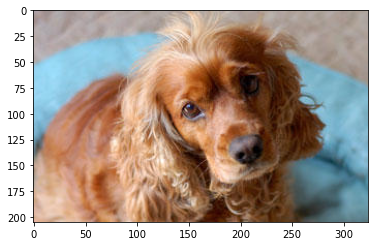

--------------------------------------
Hey, dog!
Your predicted breed is  Golden_retriever


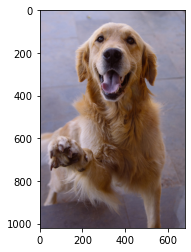

--------------------------------------
We're sorry, an error has occurred, as the subject does not appear to be a human or dog.


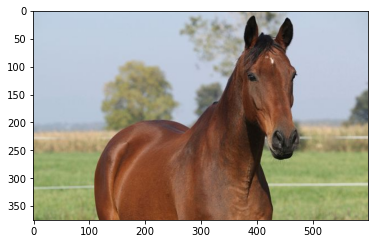

--------------------------------------
Hey, dog!
Your predicted breed is  Portuguese_water_dog


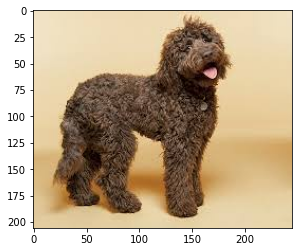

--------------------------------------
We're sorry, an error has occurred, as the subject does not appear to be a human or dog.


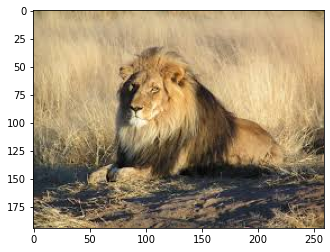

--------------------------------------
Hey, dog!
Your predicted breed is  American_staffordshire_terrier


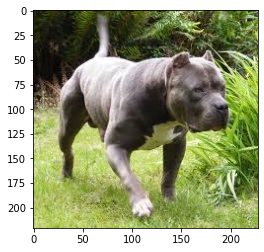

--------------------------------------
We're sorry, an error has occurred, as the subject does not appear to be a human or dog.


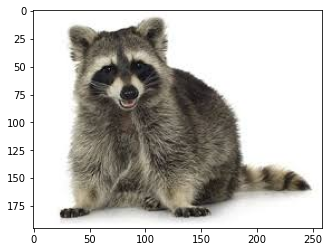

--------------------------------------


In [29]:
for file_path in glob('C:\\Users\\medipalle.tendulkar\\Desktop\\Kaggle DataSets\\Dog Breed Classifiers\\test_images\\*'):
    breed_algorithm(file_path)